In [12]:
########## Block 1 ############## <-- Please refer this block number when you ask questions
import numpy as np
# package for plotting
import matplotlib.pyplot as plt
%matplotlib inline

# scikit-learn: machine learning in Python
# https://scikit-learn.org/stable/tutorial/basic/tutorial.html
# In this example, we are using the principal component analysis 
# and the Gaussian process regression as implemented in sklearn.
# Detailed documentation of these modules:
# Principal component analysis (PCA): 
# https://scikit-learn.org/stable/modules/decomposition.html
# Gaussian process gressor (GPR)):
# https://scikit-learn.org/stable/modules/gaussian_process.html
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import \
     GaussianProcessRegressor as GPR
from sklearn.gaussian_process import kernels
from scipy.interpolate import interp1d
from scipy.integrate import quad
# suppression warning messages
import warnings
warnings.filterwarnings('ignore')

# some plot settings, not important
fontsize  = 12
plt.rcdefaults()
plt.rcParams.update({
    'font.size': fontsize,
    'legend.fontsize': fontsize,
    'axes.labelsize': fontsize,
    'axes.titlesize': fontsize,
    'xtick.labelsize': fontsize,
    'ytick.labelsize': fontsize,
    'axes.formatter.limits': (-5, 5),
    'axes.spines.top': True,
    'axes.spines.right': True,
    'legend.frameon': False,
    'image.cmap': 'Blues',
    'image.interpolation': 'none',
})


In [13]:
# Genearte correlated random function as samples of (qhat/T^3)/mean
def Mean_f(x, mean):
    return mean*np.ones_like(x)
def Var_f(x, sigma, L, N, random_state):
    kernel = sigma**2 * kernels.RBF(length_scale=L)  
    GP = GPR(kernel=kernel)
    y = GP.sample_y(np.atleast_2d(x).T, n_samples=N, random_state=random_state)
    return y
def Get_f(x, mean, sigma, L, N, random_state=31415):
    # sigma_gaussian
    sigma_gaussian = np.sqrt(np.log(sigma**2+1))
    # get mean
    meanf = Mean_f(x, mean)
    # get Gaussian Varaiton
    varf = Var_f(x, sigma_gaussian, L, N, random_state=random_state)
    # convert Gaussian varation to positive definite log-normal fluctuation
    Pvarf = np.exp(
        varf-sigma_gaussian**2/2.)
    print(Pvarf[0].mean(), Pvarf[0].std())
    f = Pvarf.T*meanf
    return f, meanf, varf

0.9133115814319654 0.6748992986301335


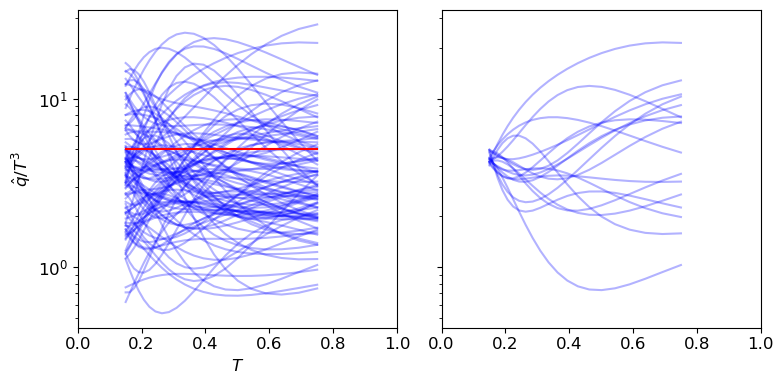

In [15]:
fig, (ax, ax1) = plt.subplots(ncols=2,nrows=1,figsize=(8,4), sharex=True, sharey=True)
Tc = 0.15
lnT = np.linspace(np.log(Tc), np.log(5*Tc), 21)
T = np.exp(lnT)

#"""
qhats, mean_qhats, var_qhats = Get_f(lnT, 5, .8, np.log(2/1), 100)
with open("Parameters/qhat_design_tables.dat", 'w') as f:
    f.write( ("#"+"{:1.5e}\t"*len(T)+"\n").format(*T) )
    for it in qhats:
        f.write( ("{:1.5e}\t"*len(T)+"\n").format(*it) )
#"""
#qhats = np.loadtxt("Parameters/qhat_design_tables.dat")

_ = ax.plot(T, qhats.T, color='b', alpha=0.3)
_ = ax.plot(T, mean_qhats, 'r-')
q0 = qhats[:, 0]
q3 = qhats[:, 0]
cut = (q3<5) & (q3>4)
_ = ax1.plot(T, qhats[cut,:].T, color='b', alpha=0.3)
ax.set_xlim(0,1)
#ax.set_ylim(0,20)
ax.set_xlabel(r"$T$")
ax.set_ylabel(r"$\hat{q}/T^3$")
ax.semilogy()
plt.tight_layout()
plt.savefig("qhat_sample.png")

In [16]:
for i, it in enumerate(qhats):
    with open("Parameters/inputs/{:d}.dat".format(i), 'w') as f:
        f.write("# T [GeV]\tqhat/T^3\n")
        for iT, iQ in zip(T, it):
            f.write( ("{:1.5e}\t{:1.5e}\n").format(iT,iQ) )

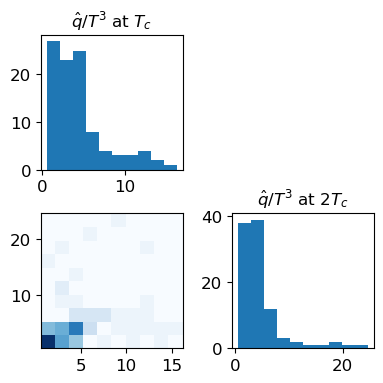

In [17]:
fig = plt.figure(figsize=(4,4))
plt.subplot(2,2,1)
_ = plt.hist(qhats.T[0])
plt.title("$\hat{q}/T^3$ at $T_c$")
plt.subplot(2,2,4)
_ = plt.hist(qhats.T[10])
plt.title("$\hat{q}/T^3$ at $2T_c$")
plt.subplot(2,2,3)
_ = plt.hist2d(qhats.T[0], qhats.T[10])
plt.tight_layout()
plt.savefig("qhat_long.png")

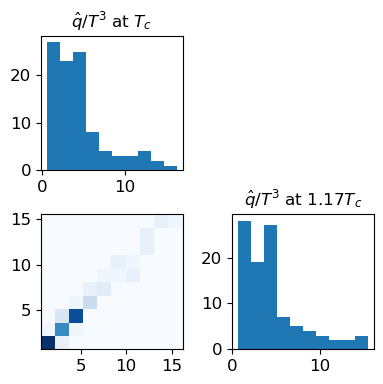

In [18]:
fig = plt.figure(figsize=(4,4))
plt.subplot(2,2,1)
_ = plt.hist(qhats.T[0])
plt.title("$\hat{q}/T^3$ at $T_c$")
plt.subplot(2,2,4)
_ = plt.hist(qhats.T[1])
plt.title("$\hat{q}/T^3$ at $1.17 T_c$")
plt.subplot(2,2,3)
_ = plt.hist2d(qhats.T[0], qhats.T[1])
plt.tight_layout()
plt.savefig("qhat_short.png")

In [19]:

def toy_quenching(lnT, qhat, T0, Tmin=1):
    f = interp1d(lnT, qhat)
    tau0 = .6*5.076
    nuE = quad(lambda T: f(np.log(T))*Tmin/T**2, Tmin, T0)[0]
    E = np.exp(np.linspace(np.log(10),np.log(200),10) )
    return E, (1-nuE*np.log(E)/(E+10))*(1+np.random.normal(0,.015, len(E)))
    

(100, 30)


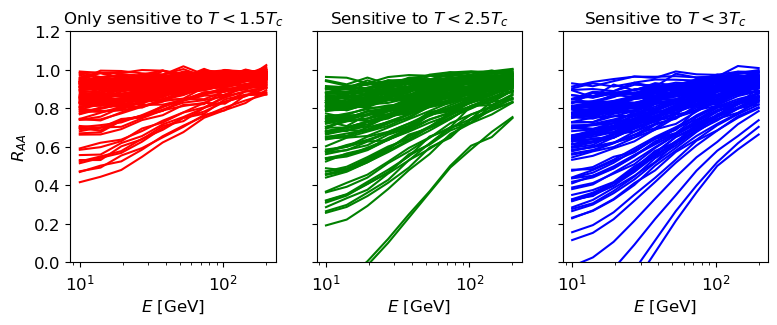

In [20]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, sharex=True, sharey=True, figsize=(9,3))
RAA = []
for qhat in qhats:
    E, r1 = toy_quenching(lnT, qhat, Tmin=Tc, T0=1.5*Tc)
    ax1.plot(E, r1,'r-')
    E, r2 = toy_quenching(lnT, qhat, Tmin=Tc, T0=2.5*Tc)
    ax2.plot(E, r2,'g-')
    E, r3 = toy_quenching(lnT, qhat, Tmin=Tc, T0=4.*Tc)
    ax3.plot(E, r3,'b-')
    #print(qhat, r1)
    RAA.append(np.concatenate([r1,r2,r3]))
ax1.set_title("Only sensitive to $T<1.5 T_c$")
ax2.set_title("Sensitive to $T<2.5 T_c$")
ax3.set_title("Sensitive to $T<3 T_c$")
ax1.set_xlabel("$E$ [GeV]")
ax2.set_xlabel("$E$ [GeV]")
ax3.set_xlabel("$E$ [GeV]")
ax1.set_ylabel("$R_{AA}$")
ax1.set_ylim(0,1.2)
ax1.semilogx()
RAA = np.array(RAA)
print(RAA.shape)

In [21]:
########## Block 15 ##############
# This class take care most of the PCA functionalities that 
# we need in this example:
# 1. Transofrm design calculations into principal components
# model_data 100 x 36 --> PCs 100 x 36 --> 36 principal components
# 2. Selection of the first N=Npc dominant PCs
# PCs 100 x 36 --> 100 x Npc dominant PCs
# 3. Transfomation of prediction in the PC space 
#    back to the original observable space
# Npc PCs --> 36 obserbvables
# 4. Transofrmation of prediction covariance in the PC space
#    back to the original observable space
# Cov Npc x Npc (diagonal) --> Cov 36 x 36 --> prediction uncertainty
class Standardlization_PCA:
    def __init__(self, data, Npc):
        self.npc = Npc
        self.scaler = StandardScaler(copy=True)
        self.pca = PCA(copy=True, whiten=True, svd_solver='full')

        # Store the first Npc tranformed observables
        self.TransformedObs = self.pca.fit_transform(self.scaler.fit_transform(data))[:,:Npc]
        # Features of each PC
        self.Features = self.pca.components_
        # The transformation matrix from PC to Physical space
        self.TransformationMatrix = (np.sqrt(self.pca.explained_variance_[:Npc])\
                                    * self.pca.components_[:Npc,:].T).T \
                                    * self.scaler.scale_

        A = (np.sqrt(self.pca.explained_variance_[Npc:])\
            * self.pca.components_[Npc:,:].T).T \
            * self.scaler.scale_
        self.ResidualCov = np.dot(A.T*1., A)
        # cumulative sum of the explained variance
        self.CumulativeVariance = np.cumsum(self.pca.explained_variance_ratio_)
    def PC2Obs(self, PCs):
        return np.dot(PCs, self.TransformationMatrix) + self.scaler.mean_
    def PCcov2Obscov(self, PCcov, with_truncation_err=True):
        results = np.matmul(self.TransformationMatrix.T*PCcov, self.TransformationMatrix)
        if with_truncation_err:
            return results+self.ResidualCov
        else:
            return results


In [22]:
########## Block 16 ##############
# Choose the number of principal components,
npc = 5
print(RAA)
# And constuct the PCA transfromer
transformer = Standardlization_PCA(RAA, Npc=npc)


[[0.98651973 0.96278545 0.96711478 ... 0.93415992 0.95751462 0.99200513]
 [0.82324126 0.86984426 0.83903946 ... 0.90451319 0.90377795 0.91632586]
 [0.80366703 0.83819632 0.84835691 ... 0.75844657 0.81996844 0.85933638]
 ...
 [0.97115474 0.94224864 0.95807787 ... 0.94414343 0.96967162 0.96732859]
 [0.85575538 0.8704066  0.89779868 ... 0.86156351 0.88898954 0.94051107]
 [0.91040799 0.89817608 0.89936487 ... 0.90267456 0.93478934 0.96326724]]


Linear correlation coefficients:  -9.524601287726188e-17


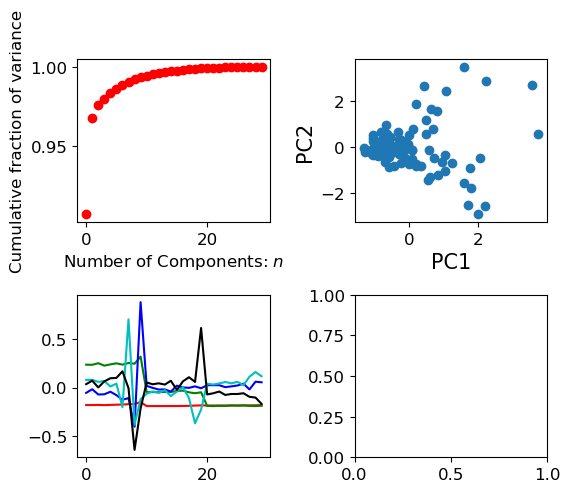

In [23]:
########## Block 17 ##############
# In this block, let's examine
# 1. Which PCs are important?
# 2. What PCs look like?
# 3. Are they linealy uncorrelated?
# 4. Are their residue non-linear correlation?
fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(ncols=2, nrows=2, figsize=(6,5))

# Subplot 1: plot the cumulative variance contained in the first 
#            n principle components
ax1.plot(transformer.CumulativeVariance,'ro')
ax1.set_xlabel(r'Number of Components: $n$')
ax1.set_ylabel('Cumulative fraction of variance')
#ax1.vlines(npc, .6, 1.2, linestyles='dashed')
#ax1.set_ylim(.6,1.05)
#ax1.semilogy()
# Subplot 2: plot the 2D scattered plot of any two PCs
#            Check the covariance between them, are they small?
#            Is there some non-linear structure in the plot?
Z1 = transformer.TransformedObs[:, 0]
Z2 = transformer.TransformedObs[:, 1]
ax2.scatter(Z1, Z2)
cov = np.cov(Z1, Z2)
print("Linear correlation coefficients: ", 
      cov[1,0]/np.sqrt(cov[0,0]*cov[1,1]))
ax2.set_xlabel('PC1', fontsize=15)
ax2.set_ylabel('PC2', fontsize=15)

for i,c in enumerate('rgbck'):
    ax3.plot(transformer.Features[i],color=c)
plt.tight_layout(True)

In [24]:
kernel = (
    1. * kernels.RBF(
        length_scale=[1.]*len(lnT),
        length_scale_bounds=np.outer(np.ones_like(lnT), (.01, 1000.))
    )  
    + kernels.WhiteKernel(
        noise_level=1., 
        noise_level_bounds=(1e-2, 1e2))
)

# Build and train each GP
gps = [ GPR(kernel=kernel, n_restarts_optimizer=20) 
        for i in range(npc) ]
for i, gp in enumerate(gps):
    gp.fit(qhats, transformer.TransformedObs[:,i])
    print('RBF: ', gp.kernel_.get_params()['k1'])
    print('White: ', gp.kernel_.get_params()['k2'])


RBF:  7.19**2 * RBF(length_scale=[1e+03, 1e+03, 62.2, 1e+03, 1e+03, 1e+03, 1e+03, 1e+03, 111, 1e+03, 1e+03, 1e+03, 1e+03, 1e+03, 1e+03, 610, 1e+03, 1e+03, 1e+03, 1e+03, 1e+03])
White:  WhiteKernel(noise_level=0.01)
RBF:  7.06**2 * RBF(length_scale=[142, 66.6, 1e+03, 1e+03, 1e+03, 1e+03, 1e+03, 1e+03, 1e+03, 102, 1e+03, 1e+03, 1e+03, 77, 1e+03, 1e+03, 1e+03, 1e+03, 1e+03, 1e+03, 1e+03])
White:  WhiteKernel(noise_level=0.0225)
RBF:  0.985**2 * RBF(length_scale=[765, 0.501, 10.9, 0.38, 20.7, 84.3, 171, 302, 514, 849, 1e+03, 1e+03, 1e+03, 466, 272, 208, 192, 231, 76.7, 0.172, 0.521])
White:  WhiteKernel(noise_level=0.01)
RBF:  0.988**2 * RBF(length_scale=[114, 48.6, 1e+03, 560, 126, 1e+03, 470, 0.0753, 185, 341, 275, 1e+03, 0.0216, 45.8, 608, 661, 1e+03, 1e+03, 449, 1e+03, 164])
White:  WhiteKernel(noise_level=0.01)
RBF:  1.01**2 * RBF(length_scale=[0.371, 1e+03, 1e+03, 1e+03, 1e+03, 1e+03, 1e+03, 1e+03, 1e+03, 1e+03, 1e+03, 1e+03, 0.152, 0.339, 1e+03, 254, 1e+03, 1e+03, 1e+03, 1e+03, 1e+0

In [25]:
########## Block 20 ##############
# This function takes parameter point as input,
# and outpus prediction of model calcualtion using GPs
# as well as the prediction uncertainty (1 sigma)
def GP_pred_at_one_input(parameter, with_truncation_err=True, addition_std=0):
    pcs, pcstd = np.array([gp.predict([parameter], return_std=True) for gp in gps]).T[0]
    pred = transformer.PC2Obs(pcs)
    pred_err = np.sqrt( np.diag( transformer.PCcov2Obscov(pcstd**2, with_truncation_err) ) )
    return pred, pred_err

1.0818633912860647 0.829009954767074


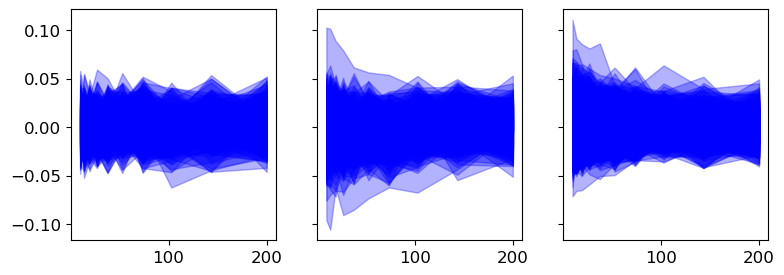

In [26]:
fig, axes = plt.subplots(1,3, figsize=(9,3), sharex=True, sharey=True)
qhats_Validate, _, _ = Get_f(lnT, 5, .8, np.log(2.), 100, random_state=3)

for qhat in qhats_Validate:
    E, r1 = toy_quenching(lnT, qhat, Tmin=Tc, T0=1.5*Tc)
    E, r2 = toy_quenching(lnT, qhat, Tmin=Tc, T0=2.5*Tc)
    E, r3 = toy_quenching(lnT, qhat, Tmin=Tc, T0=4*Tc)
    y, dy = GP_pred_at_one_input(qhat)
    y = y.reshape(3,-1)
    dy = dy.reshape(3,-1)
    for ax,iy, idy, r in zip(axes,y, dy, [r1,r2,r3]):
        ax.fill_between(E, (iy-r-idy), (iy-r+idy), color='b', alpha=.3)

(0, 12)

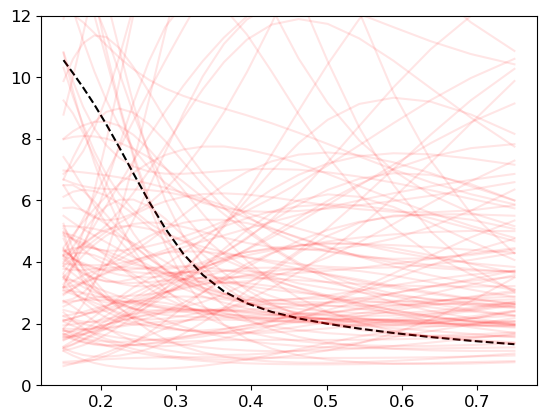

In [27]:
# True values
qhat_true = 1/(T)+4*np.exp(-(T-0.17)**2/.12**2)
plt.plot(T, qhat_true, 'k--')
plt.plot(T, qhats.T,'r-', alpha=.1)
plt.ylim(0,12)

In [28]:
########## Block 23 ##############
from scipy.linalg import block_diag
from scipy.linalg import lapack
# calculate the log of Gaussian density with 
# residual dy = y-mu and covariance matrix cov.
# - 1/2 * dy^T * cov^[-1] * dy - 1/2*ln(|cov|)
E, r1 = toy_quenching(lnT, qhat_true, Tmin=Tc, T0=1.5*Tc)
E, r2 = toy_quenching(lnT, qhat_true, Tmin=Tc, T0=2.5*Tc)
E, r3 = toy_quenching(lnT, qhat_true, Tmin=Tc, T0=4.*Tc)
yexp = np.concatenate([r1,r2,r3])
yexp = yexp*(1.+np.random.normal(0,.05, len(yexp)) )
ystat = .05*yexp
cov_exp = np.diag(ystat**2)
def lnLL(dy, cov):
    L, info = lapack.dpotrf(cov, clean=False)
    alpha, info = lapack.dpotrs(L, dy)
    return -.5*np.dot(dy, alpha)-np.log(L.diagonal()).sum()
def likelihood_ln_pdf(qhat, cut):
    pcs, pcstd = np.array([gp.predict([qhat], return_std=True) for gp in gps]).T[0]
    pred = transformer.PC2Obs(pcs)
    cov_pred = transformer.PCcov2Obscov(pcstd**2, with_truncation_err=True)
    Dy = pred-yexp
    Dy[cut:] = 0.
    return lnLL(Dy, cov_pred + cov_exp)

def calc_weight(qhat, cut):
    return likelihood_ln_pdf(qhat, cut)

In [29]:
samples, _, _ = Get_f(lnT, 5, .8, np.log(2), 10000, random_state=3)
weights1 = np.array([calc_weight(isample, cut=10) for isample in samples])
weights2 = np.array([calc_weight(isample, cut=20) for isample in samples])
weights3 = np.array([calc_weight(isample, cut=30) for isample in samples])
R = []
for qhat in samples:
    R.append(GP_pred_at_one_input(qhat)[0])
R = np.array(R)

0.9929497482953702 0.7923544924859304


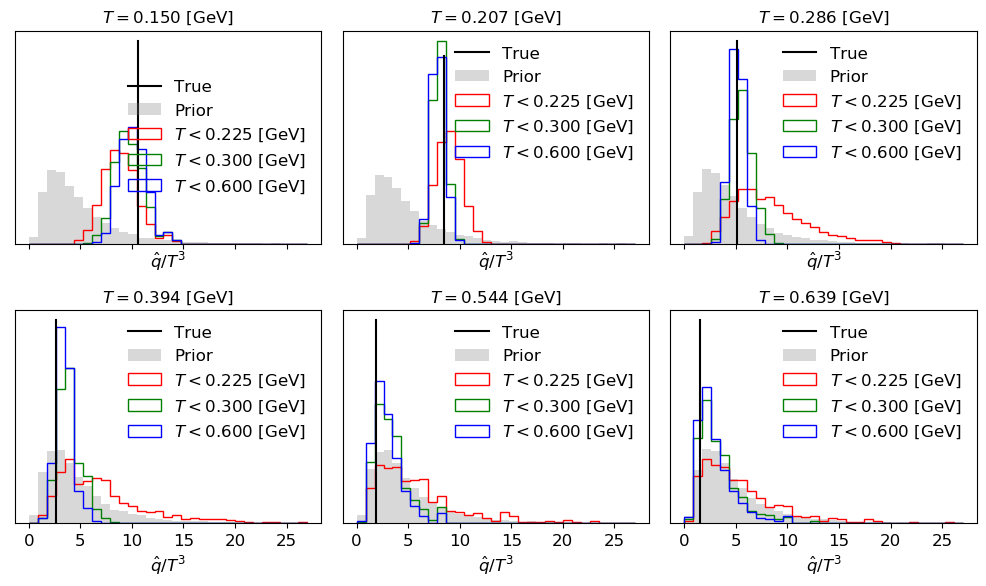

In [31]:
fig, axes = plt.subplots(2,3,figsize=(10,6), sharex=True, )
axes = axes.flatten()
for ax, iT in zip(axes,[0,4,8,12,16,18]):
    ax.set_title("$T={:1.3f}$ [GeV]".format(np.exp(lnT[iT])  ) )
    ax.plot([qhat_true[iT]]*2, [0, .5], 'k-', label='True')
    
    ax.hist(samples[:,iT], density=True, bins=31, range=[0,27],  color='gray', alpha=.3, label='Prior')
    ax.hist(samples[:,iT], weights=np.exp(weights1), density=True, bins=31, range=[0,27], 
            histtype='step', color='r', label="$T<{:1.3f}$ [GeV]".format(1.5*Tc))
    ax.hist(samples[:,iT], weights=np.exp(weights2), density=True, bins=31, range=[0,27], 
            histtype='step', color='g', label="$T<{:1.3f}$ [GeV]".format(2*Tc))
    ax.hist(samples[:,iT], weights=np.exp(weights3), density=True, bins=31, range=[0,27],
            histtype='step', color='b', label="$T<{:1.3f}$ [GeV]".format(4*Tc))

for ax in axes:
    ax.legend()
    ax.set_yticks([])
    ax.set_xlabel(r"$\hat{q}/T^3$")
plt.tight_layout(True)
plt.savefig("ToyModelTest.png",dpi=300)

No handles with labels found to put in legend.


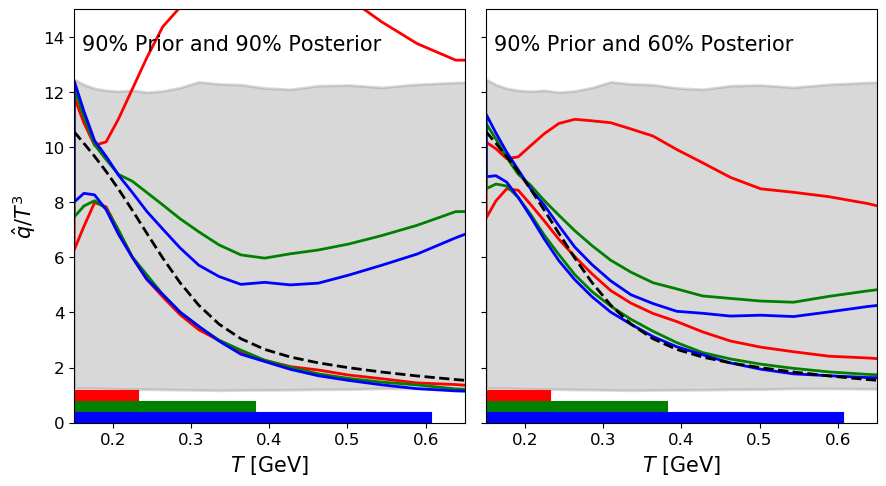

In [32]:
fig, (ax,ax2) = plt.subplots(1,2,figsize=(9,5), sharex=True, sharey=True)
def wighted_percentile(x, w, p):
    wsum = w.sum()
    index = np.argsort(x)
    x = x[index]
    w = w[index]/wsum
    s = 0.
    xid = 0
    for i, iw in enumerate(w):
        s+=iw
        if s>=p:
            xid = i
            break
    return x[xid]
    
P0 = []
P1 = []
P2 = []
P3 = []
Tid = np.arange(len(T))

for iT in Tid:
    isamples = samples[:, iT]
    w = np.ones_like(isamples)
    P0.append([wighted_percentile(isamples, w, .05), wighted_percentile(isamples, w, .95),
              wighted_percentile(isamples, w, .2), wighted_percentile(isamples, w, .8),
              wighted_percentile(isamples, w, .35), wighted_percentile(isamples, w, .65)
              ])
    w = np.exp(weights1)
    P1.append([wighted_percentile(isamples, w, .05), wighted_percentile(isamples, w, .95),
              wighted_percentile(isamples, w, .2), wighted_percentile(isamples, w, .8),
              wighted_percentile(isamples, w, .35), wighted_percentile(isamples, w, .65)
              ])
    w = np.exp(weights2)
    P2.append([wighted_percentile(isamples, w, .05), wighted_percentile(isamples, w, .95),
              wighted_percentile(isamples, w, .2), wighted_percentile(isamples, w, .8),
              wighted_percentile(isamples, w, .35), wighted_percentile(isamples, w, .65)
              ])
    w = np.exp(weights3)
    P3.append([wighted_percentile(isamples, w, .05), wighted_percentile(isamples, w, .95),
              wighted_percentile(isamples, w, .2), wighted_percentile(isamples, w, .8),
              wighted_percentile(isamples, w, .35), wighted_percentile(isamples, w, .65)
              ])
P0 = np.array(P0)
P1 = np.array(P1)
P2 = np.array(P2)
P3 = np.array(P3)

T1,T2,T3 = np.array([1.5,2.5,4])*Tc

ax.plot([.15,T3],[0.2]*2, color='b', linewidth=8)
ax.plot([.15,T2],[0.6]*2, color='g', linewidth=8)
ax.plot([.15,T1],[1]*2, color='r', linewidth=8)

ax2.plot([.15,T3],[0.2]*2, color='b', linewidth=8)
ax2.plot([.15,T2],[0.6]*2, color='g', linewidth=8)
ax2.plot([.15,T1],[1]*2, color='r', linewidth=8)

ax.fill_between(T[Tid], P0.T[0], P0.T[1], color='gray', alpha=.3, linewidth=2)
ax.fill_between(T[Tid], P1.T[0], P1.T[1], edgecolor='r', alpha=1, facecolor='none', linewidth=2)
ax.fill_between(T[Tid], P2.T[0], P2.T[1], edgecolor='g', alpha=1, facecolor='none', linewidth=2)
ax.fill_between(T[Tid], P3.T[0], P3.T[1], edgecolor='b', alpha=1, facecolor='none', linewidth=2)

ax2.fill_between(T[Tid], P0.T[0], P0.T[1], color='gray', alpha=.3, facecolor='none', linewidth=2)
ax2.fill_between(T[Tid], P1.T[2], P1.T[3], edgecolor='r', alpha=1, facecolor='none', linewidth=2)
ax2.fill_between(T[Tid], P2.T[2], P2.T[3], edgecolor='g', alpha=1, facecolor='none', linewidth=2)
ax2.fill_between(T[Tid], P3.T[2], P3.T[3], edgecolor='b', alpha=1, facecolor='none', linewidth=2)

#ax3.fill_between(T[Tid], P0.T[0], P0.T[1], color='gray', alpha=.3, facecolor='none', linewidth=2)
#ax3.fill_between(T[Tid], P1.T[4], P1.T[5], edgecolor='r', alpha=1, facecolor='none', linewidth=2)
#ax3.fill_between(T[Tid], P2.T[4], P2.T[5], edgecolor='g', alpha=1, facecolor='none', linewidth=2)
#ax3.fill_between(T[Tid], P3.T[4], P3.T[5], edgecolor='b', alpha=1, facecolor='none', linewidth=2)

ax.plot(T, qhat_true,'k--', linewidth=2)
ax2.plot(T, qhat_true,'k--', linewidth=2)
#ax3.plot(T, qhat_true,'k--', linewidth=2)

ax.legend()
ax.set_ylim(0,15)
ax.set_xlim(0.15,.65)
ax.set_ylabel(r"$\hat{q}/T^3$", fontsize=15)
ax.set_xlabel(r"$T$ [GeV]", fontsize=15)
ax2.set_xlabel(r"$T$ [GeV]", fontsize=15)
#ax3.set_xlabel(r"$T$ [GeV]", fontsize=15)
ax.annotate("90% Prior and 90% Posterior", xy=(.02,.9), xycoords="axes fraction", fontsize=15)
ax2.annotate("90% Prior and 60% Posterior", xy=(.02,.9), xycoords="axes fraction", fontsize=15)
#ax3.annotate("90% Prior and 30% Posterior", xy=(.02,.9), xycoords="axes fraction", fontsize=15)
plt.tight_layout(True)
plt.savefig("qhat.png",dpi=300)

(0, 1)

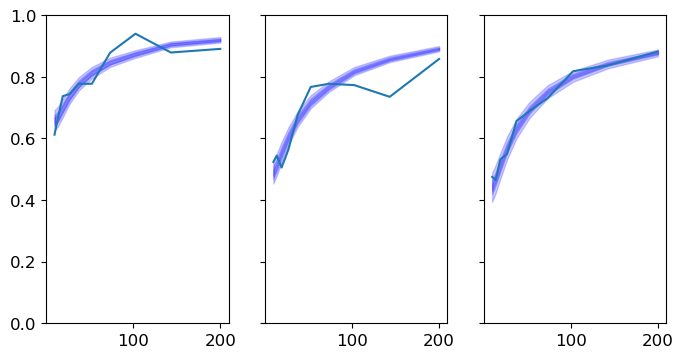

In [33]:
fig, axes = plt.subplots(1,3,figsize=(8,4), sharex=True, sharey=True)
for ax, i in zip(axes, [0,10,20]):
    ax.plot(E, yexp[i:i+10])

R1 = []
R2 = []
R3 = []
for iE in range(30):
    isamples = R[:, iE]
    w = np.ones_like(isamples)
    w = np.exp(weights1)
    R1.append([wighted_percentile(isamples, w, .05), wighted_percentile(isamples, w, .95),
              wighted_percentile(isamples, w, .2), wighted_percentile(isamples, w, .8),
              wighted_percentile(isamples, w, .35), wighted_percentile(isamples, w, .65)
              ])
    w = np.exp(weights2)
    R2.append([wighted_percentile(isamples, w, .05), wighted_percentile(isamples, w, .95),
              wighted_percentile(isamples, w, .2), wighted_percentile(isamples, w, .8),
              wighted_percentile(isamples, w, .35), wighted_percentile(isamples, w, .65)
              ])
    w = np.exp(weights3)
    R3.append([wighted_percentile(isamples, w, .05), wighted_percentile(isamples, w, .95),
              wighted_percentile(isamples, w, .2), wighted_percentile(isamples, w, .8),
              wighted_percentile(isamples, w, .35), wighted_percentile(isamples, w, .65)
              ])
R1 = np.array(R1)
R2 = np.array(R2)
R3 = np.array(R3)
for ax, i in zip(axes, [0,10,20]):
    #ax.fill_between(E, R1.T[0,i:i+10], R1.T[1,i:i+10], edgecolor='r', alpha=1, facecolor='none', linewidth=1)
    #ax.fill_between(E, R2.T[0,i:i+10], R2.T[1,i:i+10], edgecolor='g', alpha=1, facecolor='none', linewidth=1)
    ax.fill_between(E, R3.T[0,i:i+10], R3.T[1,i:i+10], color='b', alpha=.2)
    ax.fill_between(E, R3.T[2,i:i+10], R3.T[3,i:i+10], color='b', alpha=.2)
    ax.fill_between(E, R3.T[4,i:i+10], R3.T[5,i:i+10], color='b', alpha=.2)

    
    
ax.set_ylim(0,1)
#ax.semilogx()

In [34]:
# qbism: quantum v.s Bayes
# Information theory: moments of function v.s. P(f)